In [1]:
import numpy as np
import random
import json
import time
from kafka import KafkaProducer, KafkaConsumer
import matplotlib.pyplot as plt

## Variables de Ambiente

In [2]:
KAFKA_SERVER = 'lab9.alumchat.lol:9092'
TOPIC = '21438' 

## IoT en Entornos con Restricciones

In [3]:
# map tables
# directions = ["N", "NO", "O", "SO", "S", "SE", "E", "NE"]
wind_to_byte = {
    "N": "000",
    "NO": "001",
    "O": "010",
    "SO": "011",
    "S": "100",
    "SE": "101",
    "E": "110",
    "NE": "111"
}

byte_to_wind = {
    "000": "N",
    "001": "NO",
    "010": "O",
    "011": "SO",
    "100": "S",
    "101": "SE",
    "110": "E",
    "111": "NE"
}

In [4]:

def binary_string_to_byte(binary_string):
    # Ensure the binary string length is a multiple of 8
    if len(binary_string) % 8 != 0:
        raise ValueError("Binary string length must be a multiple of 8.")
    
    # Split the binary string into chunks of 8 bits (1 byte)
    bytes_list = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]
    
    # Convert each chunk into a byte
    byte_array = bytearray()
    for byte in bytes_list:
        integer_value = int(byte, 2)  # Convert the binary string to an integer
        byte_array.append(integer_value)  # Append the byte to the bytearray
    
    return bytes(byte_array)

def byte_to_binary_string(byte_obj):
    # Convert each byte to its binary representation and join them
    return ''.join(format(byte, '08b') for byte in byte_obj)


# Example byte object
byte_string = b'#\xa2,'  # Equivalent to [0x23, 0xA2, 0x2C]

# Convert to binary string
binary_string = byte_to_binary_string(byte_string)

print(f"The binary representation is: {binary_string}")

The binary representation is: 001000111010001000101100


### Encode

In [5]:
def temp_to_bytes(temp: float):
    mantissa = 100
    temp_int = int(temp*mantissa)
    binary_representation = format(temp_int, 'b')
    
    # We add padding
    if len(binary_representation) < 14:
        binary_representation = '0'*(14 - len(binary_representation)) + binary_representation

    return binary_representation

def humidity_to_bytes(humidity: int):
    binary_representation = format(humidity, 'b')
    
    # We add padding
    if len(binary_representation) < 7:
        binary_representation = '0'*(7 - len(binary_representation)) + binary_representation

    return binary_representation

def wind_to_bytes(wind_dir: str):
    return wind_to_byte[wind_dir]

def encode(dictionary: dict):
    temperature = dictionary['temperatura']
    humidity = dictionary['humedad']
    wind = dictionary['direccion_viento']
    
    temp_bytes = temp_to_bytes(temperature)
    humdity_bytes = humidity_to_bytes(humidity)
    wind_bytes = wind_to_bytes(wind)

    byte_string = temp_bytes + humdity_bytes + wind_bytes
    print(byte_string)

    byte = binary_string_to_byte(byte_string)
    print(byte)
    print('len: ', len(byte))

    return byte

encode({"temperatura": 22.8, "humedad": 69, "direccion_viento": "S"})

001000111010001000101100
b'#\xa2,'
len:  3


b'#\xa2,'

### Decode

In [6]:
def bytes_to_temp(byte_str: str):
    temp_str = byte_str[:14]
    mantissa = 100
    integer_value = int(temp_str, 2)
    temp = integer_value/mantissa
    return temp
    
def bytes_to_humidity(byte_str: str):
    humidity_str = byte_str[14:21]
    integer_value = int(humidity_str, 2)
    return integer_value

def bytes_to_wind(byte_str: str):
    wind_str = byte_str[21:24]
    return byte_to_wind[wind_str]

def decode(byte_arr: bytearray):
    byte_arr = bytes(byte_arr)
    bit_str = byte_to_binary_string(byte_arr)

    temp = bytes_to_temp(bit_str)    
    humidity = bytes_to_humidity(bit_str)    
    wind = bytes_to_wind(bit_str)

    return {
        "temperatura": temp, 
        "humedad": humidity, 
        "direccion_viento": wind
        }
    
print(decode(b'#\xa2,'))


{'temperatura': 22.8, 'humedad': 69, 'direccion_viento': 'S'}


## Simulación de Sensores

In [7]:
def get_temperature(mean_temp: int, std_dev: int):
    res = np.random.normal(mean_temp, std_dev, 1)
    res = np.clip(res, 0, 110)[0]
    return round(res, 2)

def get_humidity(mean_humidity: int, std_dev: int):
    humidity_sample = np.random.normal(mean_humidity, std_dev, 1)
    res = np.clip(humidity_sample, 0, 100)[0]
    return int(res)

def get_wind_dir():
    directions = ["N", "NO", "O", "SO", "S", "SE", "E", "NE"]
    return random.choice(directions)

def to_dict(temp: int, humidity: int, wind_dir: str):
    dictionary = {
        "temperatura": temp,
        "humedad": humidity,
        "direccion_viento": wind_dir
    }

    return dictionary

## Envío de Datos al Edge Server
Nota: El stream de datos debe detenerse manualmente, de forma que se levante un `KeyboardInterupt`.

In [8]:
def send_data(producer):
    while True:
        temperature = get_temperature(mean_temp=15, std_dev=5)
        humidity = get_humidity(mean_humidity=60, std_dev=15)    
        wind_dir = get_wind_dir()
        data = to_dict(temperature, humidity, wind_dir)
        encoded = bytearray(encode(data))

        # Genera y envía los datos        
        producer.send(TOPIC, value=encoded)
        print(f"Enviado: {data}")

        # Espera entre 15 y 30 segundos antes de enviar el siguiente dato
        time_to_sleep = random.randint(15, 30)
        time.sleep(time_to_sleep)

In [9]:
producer = KafkaProducer(
    bootstrap_servers=KAFKA_SERVER,
    value_serializer=lambda v: v
)

try:
    send_data(producer)
except KeyboardInterrupt:
    print("Process finished successfully")
finally:
    # Ensure all messages are sent
    producer.flush()
    producer.close()

000101000111100111001000
b'\x14y\xc8'
len:  3
Enviado: {'temperatura': np.float64(13.1), 'humedad': 57, 'direccion_viento': 'N'}
Process finished successfully


### Constancia
![images/producer.png](images/producer.png)

## Consumir y Desplegar Datos Meteorológicos

In [24]:
all_temp = []
all_hume = []
all_wind = []

def plot_all_data(temp_data, hume_data, wind_data):
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.plot(temp_data, color='red', label='Temperatura')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(hume_data, color='blue', label='Humedad')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(wind_data, color='green', label='Dirección del viento')
    plt.legend()

    plt.tight_layout()
    plt.show()


def process_msg(mensaje):
    payload = json.loads(mensaje.value)
    payload = json.loads(payload)
    return {
        'temperatura': payload.get('temperatura'),
        'humedad': payload.get('humedad'),
        'direccion_viento': payload.get('direccion_viento')
    }

def consume_events(consumer):
    # Consume mensajes y procesa los datos
    for msg in consumer:        
        payload = decode(msg.value)
        print(payload)
        # payload = process_msg(payload)
        
        # Agrega los datos a las listas
        all_temp.append(payload['temperatura'])
        all_hume.append(payload['humedad'])
        all_wind.append(payload['direccion_viento'])


{'temperatura': 8.18, 'humedad': 90, 'direccion_viento': 'O'}
{'temperatura': 16.8, 'humedad': 89, 'direccion_viento': 'SO'}
{'temperatura': 12.23, 'humedad': 79, 'direccion_viento': 'SO'}
{'temperatura': 13.73, 'humedad': 74, 'direccion_viento': 'S'}
{'temperatura': 10.9, 'humedad': 59, 'direccion_viento': 'SE'}
Process finished successfully


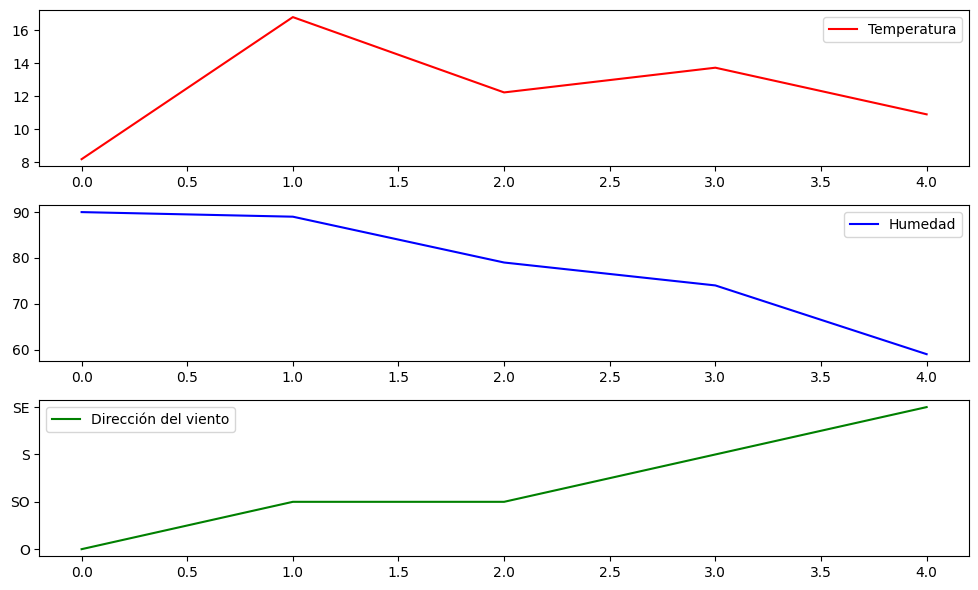

In [25]:
consumer = KafkaConsumer(
    TOPIC,    
    bootstrap_servers=KAFKA_SERVER,  
    value_deserializer=lambda x: x
)

try:
    consume_events(consumer)
except KeyboardInterrupt:
    print("Process finished successfully")
finally:     
    consumer.close()
    # Realiza un análisis o graficación de los datos
    plot_all_data(all_temp, all_hume, all_wind)